# Machine Learning for Cancer Prediction using Gene Expression Data
I will be using RNA-seq gene expression data for different cancer types. The rows represent cancer samples and the columns represent gene count values. The last column contains the cancer categories.

The data can be found here: https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq

## Import Required Libraries

In [2]:
#data handling
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.feature_selection import mutual_info_classif

#classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

## Read Data

In [3]:
df = pd.read_csv('cancer_gene_expression.csv')

## Data Exploration & Cleaning

In [7]:
# view first few rows
df.head()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_7992,gene_7993,gene_7994,gene_7995,gene_7996,gene_7997,gene_7998,gene_7999,gene_8000,Cancer_Type
0,0.0,0.0,0.0,2.088413,0.0,0.0,0.0,0.0,0.550605,2.815760,...,11.558803,8.881802,6.014840,6.643534,11.740624,7.065012,9.932659,6.928584,2.088413,KIRC
1,0.0,0.0,0.0,3.205955,0.0,0.0,0.0,0.0,0.425244,2.354396,...,11.062829,9.032864,5.054193,6.432320,12.104985,7.300746,9.872796,5.039231,2.448002,KIRC
2,0.0,0.0,0.0,4.746646,0.0,0.0,0.0,0.0,2.639417,1.657091,...,12.497640,7.198160,0.943434,7.371690,11.202356,8.426588,11.176890,3.119738,4.433988,BRCA
3,0.0,0.0,0.0,1.173191,0.0,0.0,0.0,0.0,1.527371,2.732899,...,11.261713,8.725676,6.300418,6.036451,11.732303,7.559469,9.596453,2.863046,3.380342,KIRC
4,0.0,0.0,0.0,1.366532,0.0,0.0,0.0,0.0,0.000000,3.388355,...,12.241965,7.685204,5.142948,6.355788,11.493950,8.139444,10.189256,6.544487,0.839395,COAD


In [8]:
# view shape
df.shape

(801, 8001)

In [9]:
# note: last column contains labels
df.columns[-1]

'Cancer_Type'

In [10]:
# check for missing values
datanul = df.isnull().sum()
g = [i for i in datanul if i>0]

print('columsn with missing values:%d'%len(g))

columsn with missing values:0


In [11]:
# check cancer types
df['Cancer_Type'].value_counts()

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

This shows us 5 different types of cancer with their respective number of samples diagnosed.

<Axes: xlabel='Cancer_Type'>

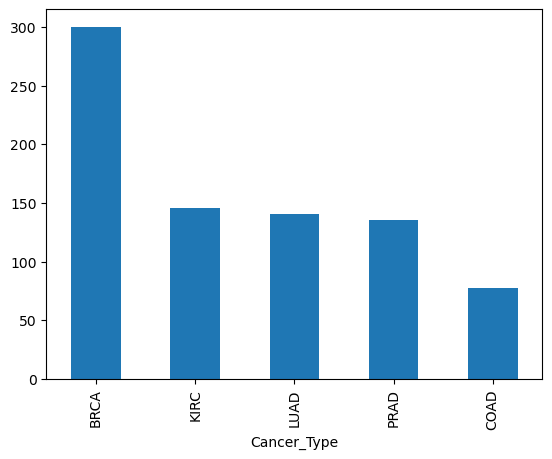

In [13]:
# plot cancer types as bar chart to view distribution
df['Cancer_Type'].value_counts().plot.bar()

## Data Preprocessing
This is done to format the data before modeling.

In [14]:
# separate data into features (X) and class (y)
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

X.shape

(801, 8000)

In [15]:
y.shape

(801,)

**Encode Labels**

The labels for this data are categorical so we must convert them to numerical (referred to as encoding). Machine learning models usually require input data to be in numeric forms, hence we encode the labels. 

In [16]:
# encode target labels (y) with values between 0 and n_classes-1
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)

In [17]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [18]:
classes

array([0, 1, 2, 3, 4])

**Data Splitting**

Now we will split the data into training and testing sets. The training data is initally parsed into the machine learning model. This is to enable the model to identify discriminatory patterns which can be used to make future predictions. The testing data is used to evaluate the model after the training phase. 

In [19]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [20]:
df.iloc[:, 0:10].describe()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


**Data Normalization**

Data normalization is done so that the values are within the same range. This improves model performance and avoids bias. 

In [21]:
# scale data between 0 and 1
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

## Feature Selection
The purpose of feature selection is to select relevant features for classification. Feature selection is usally used as a pre-processing step before doing the actual learning. 

We will use the mutual information algorithm to compute the relevance of each feature. The top n features are slected for the machine learning analysis.

In [22]:
MI = mutual_info_classif(X_train_norm, y_train)

In [23]:
# select top n features (300)
n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]

In [24]:
X_train_selected = X_train_norm[:, selected_scores_indices]
X_test_selected = X_test_norm[:, selected_scores_indices]

In [25]:
X_train_selected.shape

(640, 300)

In [26]:
X_test_selected.shape

(161, 300)

## Classification
Because we are working with pre-categorized data, this project will utilized supervised leanring. The random forest classification model works with multiclass and high dimensional data which will be great for our data.

### Model Training
Training allows the machine learning model to learn from the data and use the identified patterns to predict the outcomes of data it has never seen before. In the training phase, the model is given the training subset.

In [27]:
# Random Forest Classifier
# because we are dealing with multiclass data, the one versus rest strategy is used
# learn to predict each class against the other

RF = OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected, y_train)
y_pred = RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

### Model Evaluation
After training the model, it is important to know how the model performs on an independent data(i.e. the test data). The following metrics are used to evaluate the model:

- accuracy
- precision
- recall
- f1 score
- confusion matrix
- ROC Curve

In [28]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9833
precision:0.9880
recall:0.9876
f1score:0.9874


classification report


              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        28
        LUAD       1.00      0.92      0.96        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.99       161
weighted avg       0.99      0.99      0.99       161



In [29]:
# generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)

In [30]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,60,0,0,0,0
COAD,0,16,0,0,0
KIRC,0,0,28,0,0
LUAD,2,0,0,22,0
PRAD,0,0,0,0,33


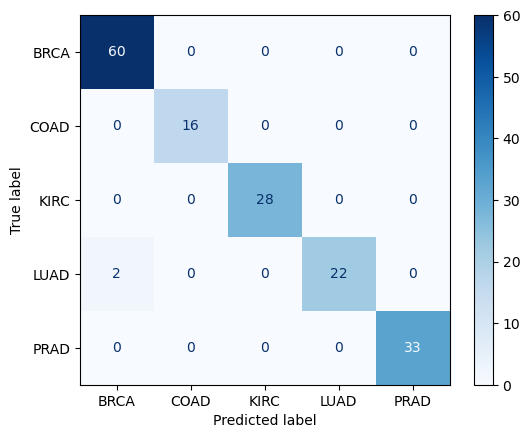

In [33]:
#visualize the confusion matrix directly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

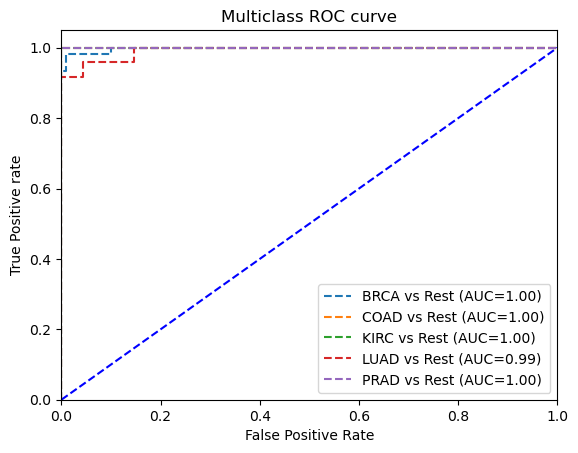

In [34]:
# roc curves will be generated for each class
# we will therefore have to binarize the y_test labels
# this is done because the probabilities(pred_prob) are calculated for each each class
# we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()   